# This script is for approximating the distribution EDS elements of a cross sectional sample

## How do I grab the Rheology data?
Step 1, once you've measured an EDS map of the JEOL SEM, the data is saved as a part of a "project" under data management. Go to data management.
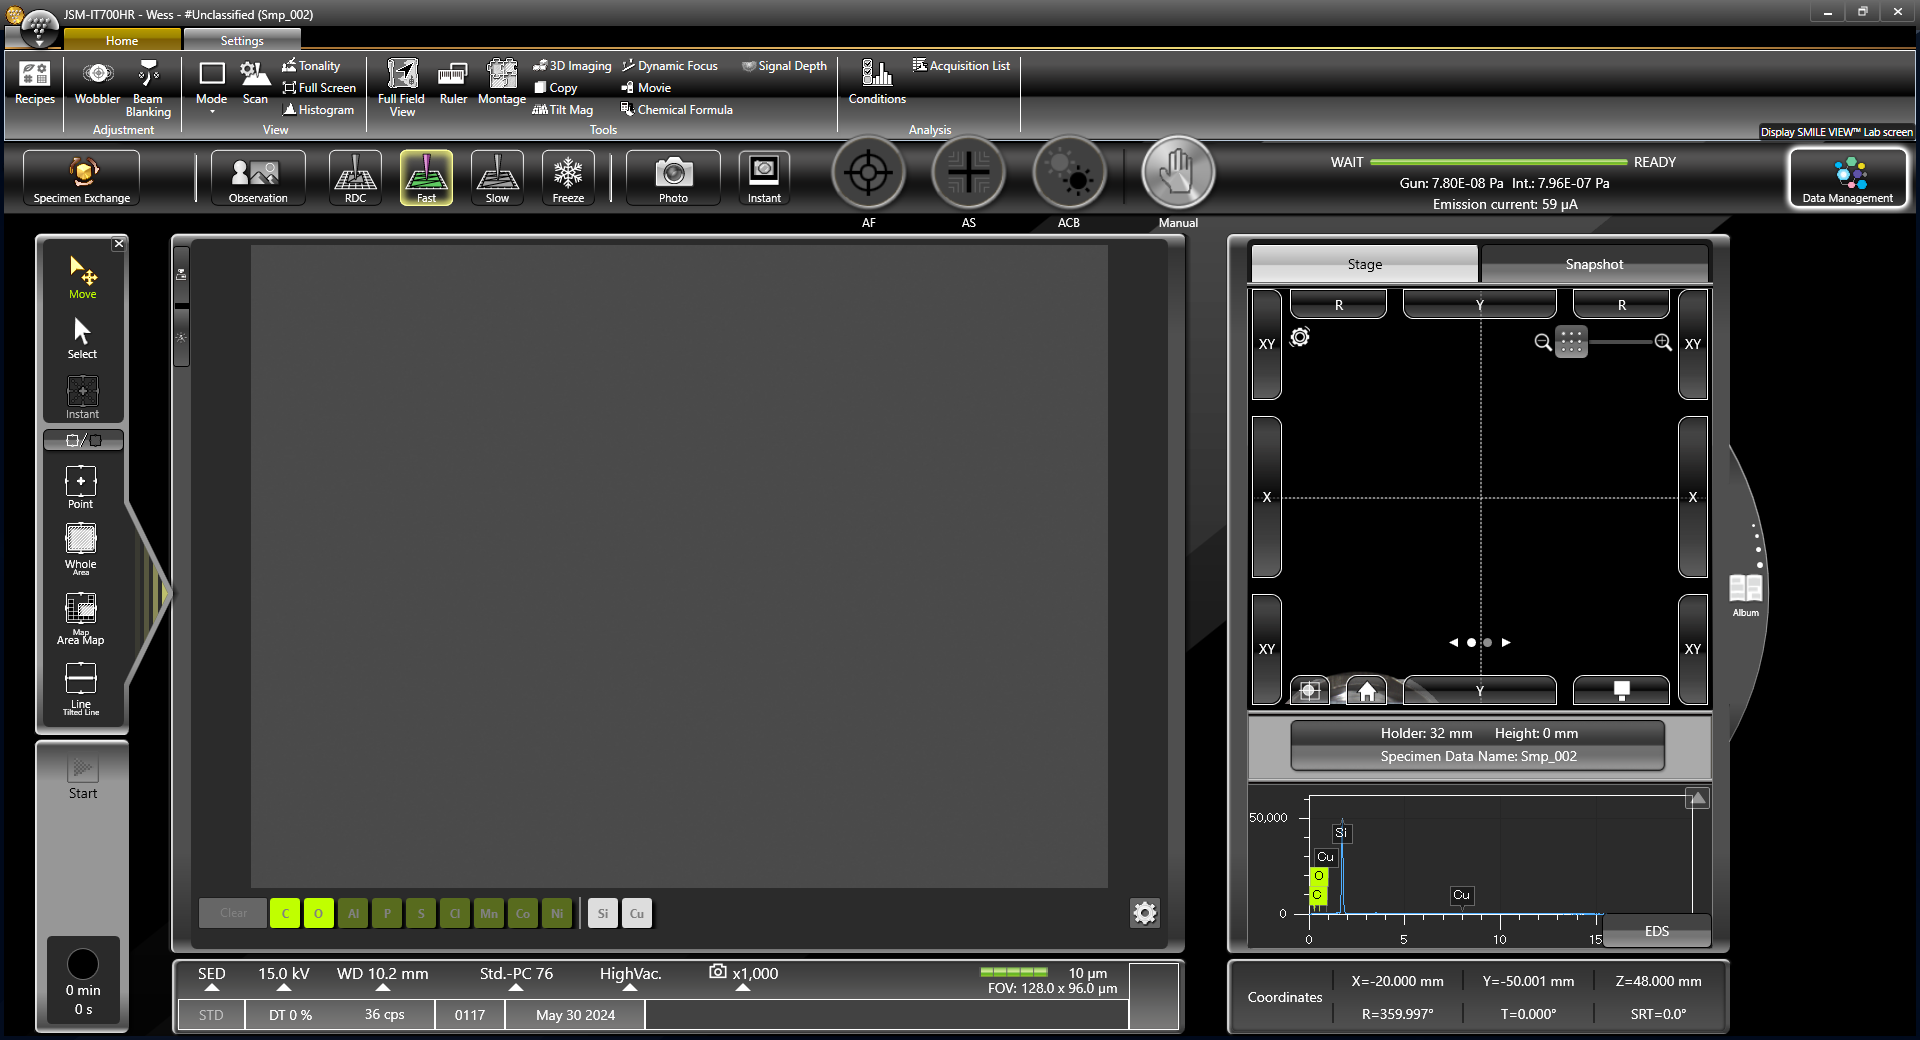

Step 2, find the EDS map made (it helps to familiarize yourself with how SEM images and maps are arranged into a project) and right-click on the map -- click *Save in another file format* and save the map in two forms: as a .bmp files, and as .csv files.
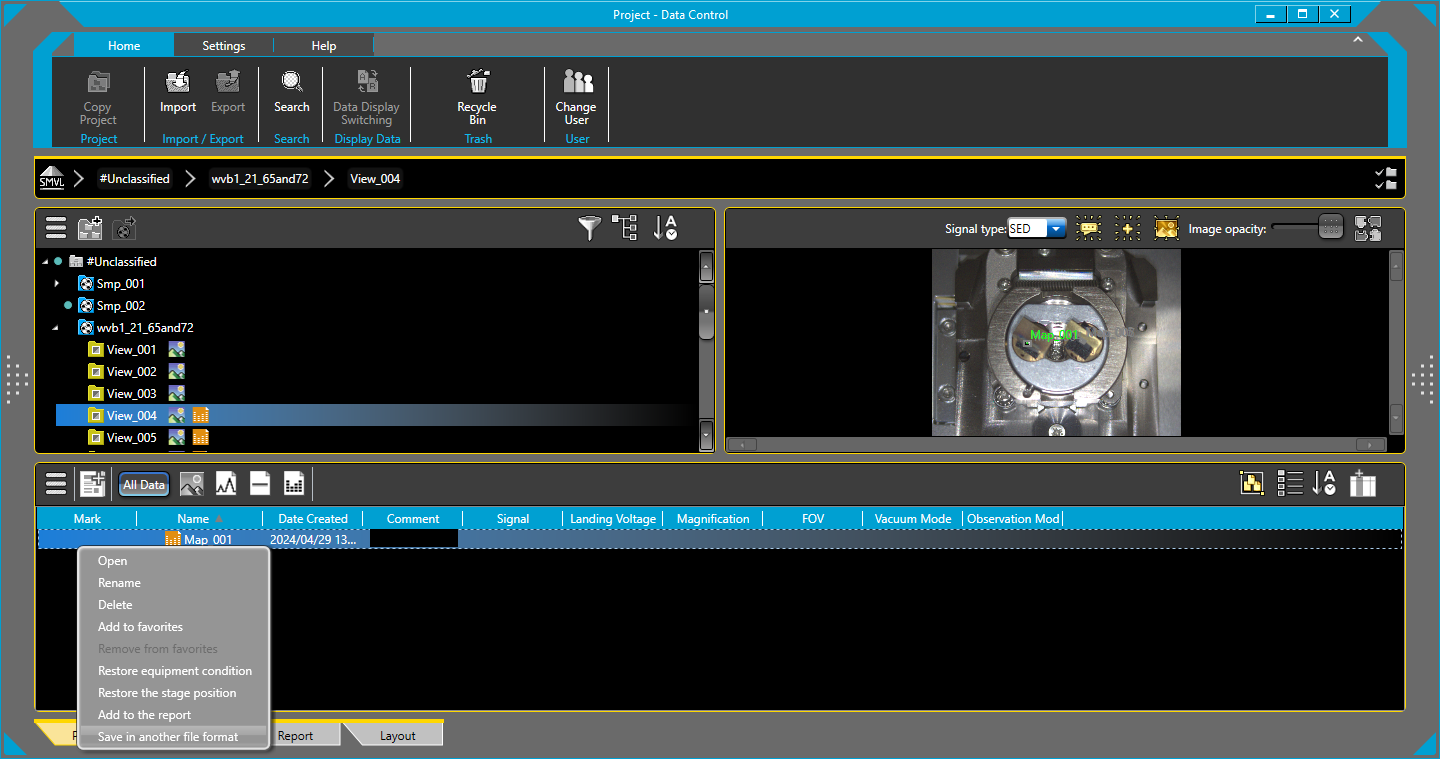

## How should the format be for the files?

You can extract raw EDS data as excel files. In additon you should have an image of the area measured handy for reference. 

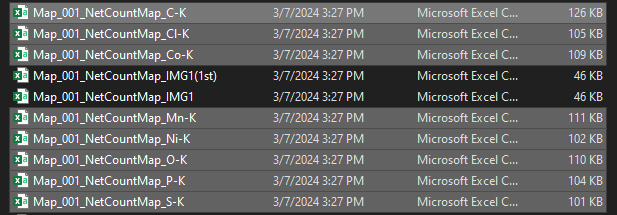

For the reference image we want a *.BMP* file because it has color and eliminates the risk of error when we get size calibration -- If you have Al or Cu substrate -- select that one!

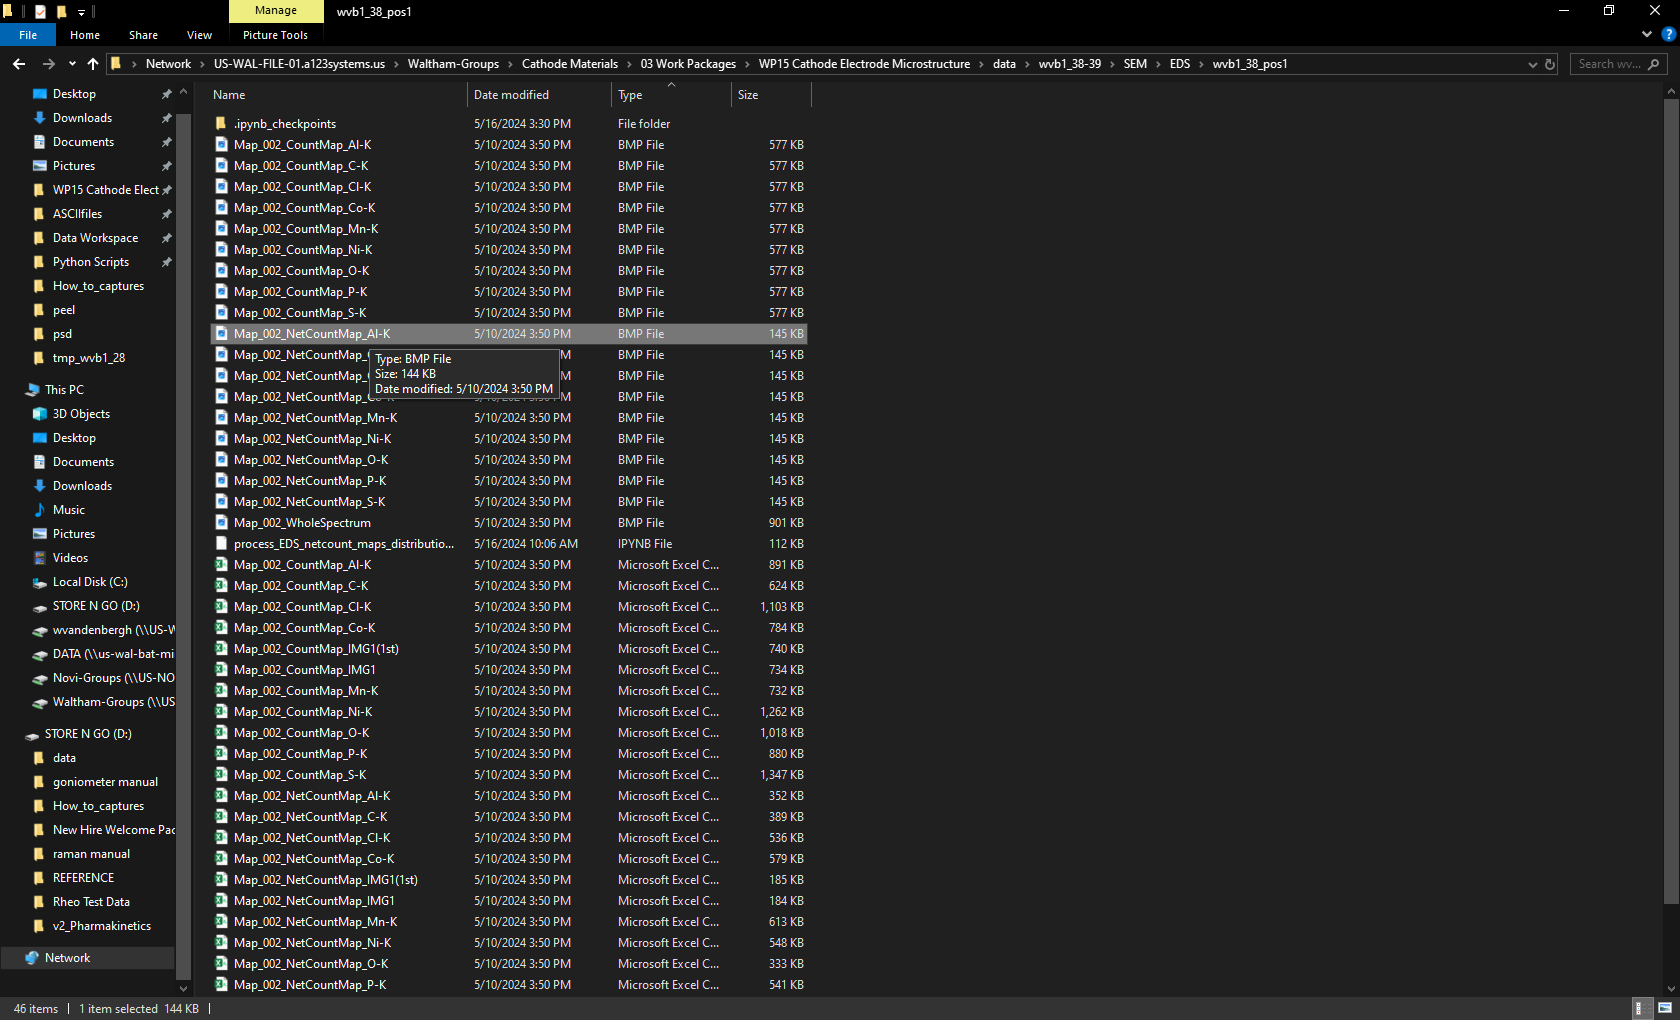

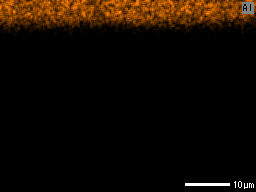

## How do I use this script? I don't know any coding...

No problem, if you can hit Shift+Enter and type into prompts then you are fine.

### Step 1

You should see a blue bar to the left of this text, this refers to which part of the code the system will read next. To have the system read the code, just hit Shift+Enter and it will go to the next "Cell"

### Step 2

Each cell will have a Blurb at the top with a # before it, this is meant to tell you what the cell is doing. There are some cells that you don't need to worry about changing and others that only need very minor input.

Read the blurb, if it says "#Don't worry about it", then just hit Shift+Enter

You can tell if the cell is done running by either an output such as a number or plot OR it will read "DONE"


In [ ]:
#Author: Wess van den Bergh
#Date Modified: May 16, 2024
#Environment: v2_Pharmakinetics
#Verified By: 

#Notes, known errors, desired features

# need to update the color mapping
# add minor ticks to bmp image
# determine a better method to do statistics and compilation of values
# double check the distribution of values and its method of analysis if this is truly the best method

print("DONE")

In [ ]:
#Don't worry about it, just hit Shift+Enter

#loads necessary packages
import skimage as ski
import matplotlib.pyplot as plt
import cmcrameri as cmc
import numpy as np
from tkinter import*
import pandas as pd
import os


def import_data(multiple_TF):
    
    """
    grabs the data needed for analysis with a GUI
    """
    # Create Tk root
    root = Tk()
    # Hide the main window
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)

    from tkinter import filedialog
    infiles = filedialog.askopenfilename(multiple=multiple_TF)

    %gui tk
    
    return infiles



def process_EDS_count_maps_distribution(infiles, 
                                        image_array, 
                                        scalebar_point, 
                                        scalebar_size, 
                                        film_dir, 
                                        al_trim, 
                                        film_end_trim = 0,
                                        mvng_avg = 5):

    """
    splits the elements grabbed from the files into their respective teams,
    integrates the individual element intensities by row and compares the integrated intensity to the average
    this comparison is representated as a deviation from the average (which is valued at 0)
    This is then plotted in their respective groups and basic stats are given
    """
    #Size of points in the plot, 15 is a good number
    point_size = 15
    
    #Line width of the moving average, 3 is good
    line_width = 3
    
    #Size of the box around the plot, 4 is fine
    box_size = 4
    
    #Font size of the axis labels and numbers
    ax_font_size = 14
    
    #Font size of the legend
    legend_font_size = 10
    
    #Do you want tick marks? True for yes, False for no
    tick_marks = True
    
    #Size of the tick marks on the x and y axis
    tick_mark_length = 10
    
    #Where the legend should go, best, upper/lower right/left, ex. upper left, KEEP quotation marks around the words
    legend_pos = "upper left"
    
    #X limits on plot
    x_lims = (-1,1)
    
    #finding scale scalebar size in pixels
    j = image_array.shape[0] - 3
    while np.all(image_array[j, scalebar_point] != np.array([255, 255, 255])):
        j -= 1
    j -= 1
    
    while np.all(image_array[j, scalebar_point] == np.array([255, 255, 255])):
        scalebar_point -= 1
    scalebar_point_start = scalebar_point
    
    scalebar_point += 1
    while np.all(image_array[j, scalebar_point] == np.array([255, 255, 255])):
        scalebar_point += 1
    scalebar_point_end = scalebar_point
    
    scalebar_pixel_length = scalebar_point_end - scalebar_point_start
    micron_per_pixel = scalebar_size / scalebar_pixel_length
    
    #setting down what elements go to what component
    cthd_elmnts = ('Mn', 'Co', 'Ni') 
    ltrlyt_elmnts = ('P', 'Cl', 'S')
    bindcarb_elmnts = tuple('C')

    if isinstance(bindcarb_elmnts, str):
        bindcarb_elmnts = tuple(bindcarb_elmnts)
    
    if isinstance(ltrlyt_elmnts, str):
        ltrlyt_elmnts = tuple(ltrlyt_elmnts)
    
    if isinstance(cthd_elmnts, str):
        cthd_elmnts = tuple(cthd_elmnts)

    #Used to determine which elements we want to analyze from EDS, used later
    bindcarb_elmnts_chk = tuple('_' + s + '-K' for s in bindcarb_elmnts)
    ltrlyt_elmnts_chk = tuple('_' + s + '-K' for s in ltrlyt_elmnts)
    cthd_elmnts_chk = tuple('_' + s + '-K' for s in cthd_elmnts)
    
    columns = ['filepath','element', 'team']
    custom_labels = pd.DataFrame(columns = columns)
    
    custom_labels = pd.concat([custom_labels, pd.DataFrame([{} for _ in range(len(infiles))])], ignore_index=True)

    #building a dataframe for labels, ids, and data file paths
    for i,path in enumerate(infiles): 
        custom_labels.loc[i, 'filepath'] = path
        
        temp_filename = os.path.basename(path)
        
        for s in cthd_elmnts_chk:
            if s in temp_filename:
                custom_labels.loc[i, 'team'] = 'cathode'
                custom_labels.loc[i, 'element'] = cthd_elmnts[cthd_elmnts_chk.index(s)]
    
        for s in ltrlyt_elmnts_chk:
            if s in temp_filename:
                custom_labels.loc[i, 'team'] = 'electrolyte'
                custom_labels.loc[i, 'element'] = ltrlyt_elmnts[ltrlyt_elmnts_chk.index(s)]
    
        for s in bindcarb_elmnts_chk:
            if s in temp_filename:
                custom_labels.loc[i, 'team'] = 'bindercarbon'
                custom_labels.loc[i, 'element'] = bindcarb_elmnts[bindcarb_elmnts_chk.index(s)]
            
    
    custom_labels_sorted = custom_labels.sort_values(by = 'team')
    unique_teams = custom_labels_sorted['team'].unique()

    #analysis of data compiled into one big dataset that will be split again in a moment
    for team in unique_teams:
        forloop_group = custom_labels_sorted[custom_labels_sorted['team'] == team]
    
        for j in range(len(forloop_group)):
            temp_data = pd.read_csv(forloop_group.iloc[j]['filepath'], header = None)

            #trim the portion of the array that is just Al and not film
            if film_dir == "down": #& al_trim != 0:
                if film_end_trim != 0:
                    temp_data = temp_data.iloc[al_trim:film_end_trim]
                else:
                    temp_data = temp_data.iloc[al_trim:]
                
            elif film_dir == "up": #& al_trim != 0:
                if film_end_trim != 0:
                    temp_data = temp_data.iloc[film_end_trim:-al_trim]
                else:
                    temp_data = temp_data.iloc[:-al_trim]
            else:
                pass

            temp_sum_data = pd.DataFrame.sum(temp_data, axis = 1) #integrate down rows
            temp_mean = temp_sum_data.mean()
    
            temp_rel_data = (temp_sum_data / temp_mean) - 1 #returns normalized data with relative difference from the mean
            temp_rel_datadf = temp_rel_data.to_frame(name = 'rel_diff') #Renames column
            temp_rel_datadf['pxl'] = temp_rel_datadf.reset_index(drop=True).index[::-1] #Gives pixel values to integrated data
            temp_rel_datadf['element'] = forloop_group.iloc[j]['element'] #Adds a tag to this data as to what element it came from
            temp_rel_datadf['team'] = forloop_group.iloc[j]['team'] #Adds a tag to this data as to what team it came from

            try:
                grand_data = pd.concat([grand_data, temp_rel_datadf], ignore_index = True)
            except NameError:
                grand_data = temp_rel_datadf
                
    #plot individual points and by team
    cthd_data = grand_data[grand_data['element'].isin(cthd_elmnts)]
    bindcarb_data = grand_data[grand_data['element'].isin(bindcarb_elmnts)]
    ltrlyt_data = grand_data[grand_data['element'].isin(ltrlyt_elmnts)]
    
    team_dfs = [cthd_data, bindcarb_data, ltrlyt_data]
    
    for df in team_dfs:
    
        df_grp = df.groupby('element')
        
        fig, ax = plt.subplots(figsize = (8,6))

        #plotting individual elements
        for name, group in df_grp:
            if film_dir == 'down': #flips the direction of the depth to account for the film depth
                plt.scatter(group['rel_diff'], (group['pxl'].values[::-1] * micron_per_pixel), label = name, s = point_size)
            elif film_dir == 'up':
                plt.scatter(group['rel_diff'], (group['pxl'] * micron_per_pixel), label = name, s = point_size)
    
        
        srs_pxlmean = df['rel_diff'].groupby(df['pxl']).mean()
        srs_pxlmvmean = srs_pxlmean.rolling(window = mvng_avg).mean()
        df_pxlmvmean = pd.DataFrame(srs_pxlmvmean)
        df_pxlmvmean['pxl'] = df_pxlmvmean.index
        df_pxlmvmean = df_pxlmvmean.rename(columns = {'rel_diff' : 'mvg_avg'})
        
        if df_pxlmvmean.empty:
            pass
        else: 
            if film_dir == 'down': #flips the direction of the depth to account for the film depth
                plt.plot(df_pxlmvmean['mvg_avg'],(df_pxlmvmean['pxl'].values[::-1] * micron_per_pixel), color = 'black', linewidth = line_width)
                plt.gca().invert_yaxis()

            elif film_dir == 'up':
                plt.plot(df_pxlmvmean['mvg_avg'],(df_pxlmvmean['pxl'] * micron_per_pixel), color = 'black', linewidth = line_width)
        
        
            min_value = float("{:.4f}".format(df_pxlmvmean['mvg_avg'].min()))
            max_value = float("{:.4f}".format(df_pxlmvmean['mvg_avg'].max()))
            mvg_avg_micron = float("{:.4f}".format(mvng_avg*micron_per_pixel))

            print(f"Min Mvg Avg: {min_value}")
            print(f"Max Mvg Avg: {max_value}")

            ax.text(-0.95, 0.35*(df_pxlmvmean['pxl'] * micron_per_pixel).max(), f"Min Mvg Avg: {min_value}", fontsize = legend_font_size, color = 'blue', fontweight = 'bold')
            ax.text(-0.95, 0.40*(df_pxlmvmean['pxl'] * micron_per_pixel).max(), f"Max Mvg Avg: {max_value}", fontsize = legend_font_size, color = 'blue', fontweight = 'bold')
            ax.text(-0.95, 0.45*(df_pxlmvmean['pxl'] * micron_per_pixel).max(), f"Mvg Avg (micron): {mvg_avg_micron}", fontsize = legend_font_size, color = 'blue', fontweight = 'bold')
            # plt.plot(df_pxlmvmean['mvg_avg'],(df_pxlmvmean['pxl'] * micron_per_pixel), color = 'black', linewidth = line_width)

            plt.xlim(x_lims)

            legend = plt.legend(framealpha=1, frameon=True, fontsize=legend_font_size, loc=legend_pos)
            frame = legend.get_frame()
            frame.set_edgecolor('black')  # Set legend box color
            frame.set_linewidth(2)        # Set legend box thickness
            for text in legend.get_texts():
                text.set_fontweight('bold')

                # Add labels and title
            plt.xlabel('Relative Deviation',  fontsize = ax_font_size, fontweight = 'bold')
            plt.ylabel('Film Depth (micron)',  fontsize = ax_font_size, fontweight = 'bold')
            plt.xticks(fontsize=ax_font_size, fontweight='bold')
            plt.yticks(fontsize=ax_font_size, fontweight='bold')

            if tick_marks == True:
                plt.tick_params(axis='both', direction='in', length=tick_mark_length)  # Set the length of tick marks

            plt.box(True)
            plt.gca().spines['top'].set_linewidth(4)    # Set top spine thickness
            plt.gca().spines['bottom'].set_linewidth(4) # Set bottom spine thickness
            plt.gca().spines['left'].set_linewidth(4)   # Set left spine thickness
            plt.gca().spines['right'].set_linewidth(4)  # Set right spine thickness

                        
print("DONE")

In [ ]:
#Don't worry about it, just hit Shift+Enter -- grab the CSV files (net count) that you want to analyze

csv_files = import_data(multiple_TF = True) #Grab CSV files for analysis

In [ ]:
#Don't worry about it, just hit Shift+Enter -- grab the Al/Cu BMP file ideally for determining the cutoff

img_reference = import_data(multiple_TF = False) #Grab Al/Cu BMP file for EDS reference

image_ref_array = ski.io.imread(img_reference)
ski.io.imshow(image_ref_array)

In [ ]:
#Look at the EDS image above and determine at what point a vertical line would intersect with the scale bar
#This is typically around 200 pixel
#Additionally put down the scale bar length in microns (usuaully 10 microns)
#The next two 
process_EDS_count_maps_distribution(csv_files,
                                    image_ref_array,
                                    scalebar_point = 215, #where would a vertical line cross the scale bar?
                                    scalebar_size = 10, #what is the scale bar size?
                                    film_dir = 'down', #Is the current collector on the top? Then the film is facing 'down', otherwise it is facing 'up'
                                    al_trim = 45, #what pixel value do you need to crop off the current collector to have accurate distribution measurements
                                    mvng_avg = 10, 
                                    film_end_trim = 150) #moving mean for elements of electrolyte and cathode

## How do I save my plot?

Shift+Right Click the plot and save the image!

## I want to change something!

No problem, just click the circular arrow and it will ask you if you do want to restart the kernel? Click restart kernel?

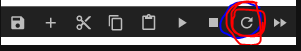

This isn't necessary if you are familiar with coding but if you want a clean slate, just go ahead and do it and start from the beginning